# Figure 6

In [1]:
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib as mpl
import scipy.stats as stats

from scipy.optimize import curve_fit

area=4.0;linethicknes=1.0;
font = {'family' : 'normal','weight' : 'normal','size'   : 7, 'family':'serif','serif':['Arial']}
mpl.rc('font', **font)
mpl.rcParams['lines.linewidth'] =linethicknes
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['pdf.fonttype'] = 42

N_stat=10**3;

def phi(x):
    return (0.5*(x+np.abs(x)))


# Load data

In [4]:
#######################################
folder_data='./../../DataAndScripts/experimental_data/'
#######################################

data_monkeys=np.loadtxt(folder_data+'Monkeys_with_trials.txt');
data_mice=np.loadtxt(folder_data+'Mice_with_trials.txt');

DATA=[data_mice,data_monkeys]
species=['Mice','Monkeys']
color=['c','m']
bin_edges=np.arange(-300,300,0.1) 
bin_means=(bin_edges[1::]+bin_edges[0:-1])/2   



# Load model simulations 

In [5]:

#######################################
folder_sims='./generate_simulations/'
#######################################


model_unstructured_mice=np.load(folder_sims+'/RATES_unstructured_mice.npy')
model_unstructured_monkeys=np.load(folder_sims+'/RATES_unstructured_monkeys.npy')

model_structured_mice=np.loadtxt(folder_sims+'/RATES_structured_mice.txt').reshape((7,2,-1))
model_structured_monkeys=np.loadtxt(folder_sims+'/RATES_structured_monkeys.txt').reshape((6,2,-1))

MODEL=[[model_unstructured_mice,model_unstructured_monkeys],
      [model_structured_mice,model_structured_monkeys]]

# Make Figure

4.164225076093314 0.4748267945924203 8.870496559784941
-0.6136904779261003 2.398501988668036 43.50488568877118


"\npic_name='Figure_6.pdf'\nfig.savefig(pic_name,format='pdf',bbox_inches='tight', dpi=300)\npic_name='Figure_6.png'\nfig.savefig(pic_name,format='png',bbox_inches='tight', dpi=300)"

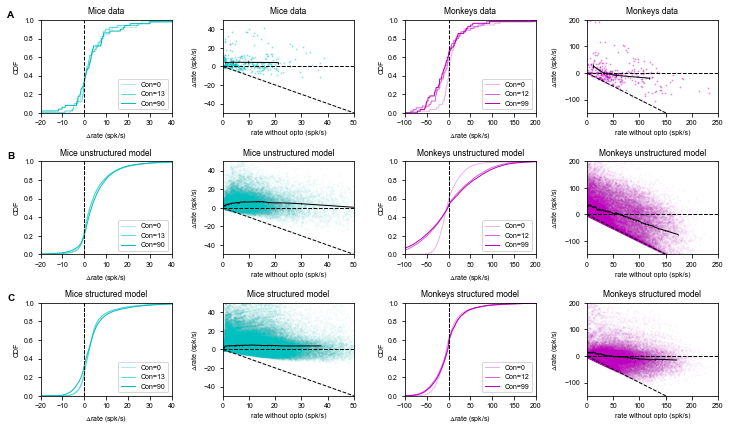

In [6]:
rows=3;cols=4;
fig, axs = plt.subplots(rows,cols, figsize=(2.5*cols,2.*rows), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)
area=4.0;linethicknes=1.0;
axs = axs.ravel()


idx_laser=-1

for idx_species in [0,1]:
    data=DATA[idx_species]
    
    Con=np.unique(data[:,1])
    Las=np.unique(data[:,2])
    cells_id=np.unique(data[:,0]);
    Las=[Las[0],Las[-1]]

    ##################################################################  
    ##################################################################
    ### DATA
    ##################################################################
    ##################################################################

    title=['Mice data','Monkeys data'][idx_species]
    
    idx_plot=2*idx_species+(0)*cols
    axs[idx_plot].set_title(title)    
 
    Cell_Resp=np.zeros((len(cells_id),len(Con),len(Las),))
    for idx_cell in range(len(cells_id)):
        for idx_con in range(len(Con)):
            for idx_las in range(len(Las)):
                mask=(data[:,0]==cells_id[idx_cell])&(data[:,2]==Las[idx_las])&(data[:,1]==Con[idx_con])
                Trial_Resp=data[mask,3::]
                Cell_Resp[idx_cell,idx_con,idx_las]=np.mean(Trial_Resp[np.isnan(Trial_Resp)==False])

                
    for idx_con in range(len(Con)):
        Base=Cell_Resp[:,idx_con,0]
        Resp=Cell_Resp[:,idx_con,-1]
        
        
    xmin=[-20,-100][idx_species]
    xmax=[40,200][idx_species]
        
    alpha=[0.3,0.6,1.0]
    count=0
    for idx_con in [0,2,-1]:
        Delta=Cell_Resp[:,idx_con,-1]-Cell_Resp[:,idx_con,0]
        hist=np.histogram(Delta,bin_edges,density=True)
        axs[idx_plot].plot(bin_means,np.cumsum(hist[0])*np.diff(bin_edges),c=color[idx_species],alpha=alpha[count],label='Con=%d'%Con[idx_con])
        count=count+1

    axs[idx_plot].legend(loc='lower right')   #prop={'size': 6},     
    axs[idx_plot].axis([xmin,xmax,0,1])
    axs[idx_plot].set_xlabel(r'$\Delta$rate (spk/s)')
    axs[idx_plot].set_ylabel('CDF')
    axs[idx_plot].axvline(x=0,c='k',ls='--')
    
    
    idx_plot=2*idx_species+(0)*cols+1
    axs[idx_plot].set_title(title)    
 
    Base=Cell_Resp[:,:,0].ravel()
    Delta=(Cell_Resp[:,:,-1]-Cell_Resp[:,:,0]).ravel()
         
    axs[idx_plot].scatter(Base,Delta,marker='o',c=color[idx_species],
                               s=1,label=species[idx_species],alpha=0.3)
    print(np.mean(Delta),stats.sem(Delta), np.std(Delta))
    axs[idx_plot].axhline(y=0,ls='--',c='k')
    axs[idx_plot].set_ylabel('$\Delta$rate (spk/s)')
    axs[idx_plot].set_xlabel('rate without opto (spk/s)')
    npercentiles=4
    hist=np.histogram(Base,bin_edges,density=True)
    Base_CDF=np.cumsum(hist[0])*np.diff(bin_edges)

    base_pc=np.zeros(npercentiles)
    delta_pc=np.zeros((npercentiles,2))    
    tests=np.zeros(npercentiles);# Welch's t-test, and F-tesr
    for idx_pc in range(npercentiles):
        lower_bound=bin_means[np.argmin(np.abs(Base_CDF-1./npercentiles*idx_pc))]
        upper_bound=bin_means[np.argmin(np.abs(Base_CDF-1./npercentiles*(idx_pc+1)))]
        mask_base=(Base>=lower_bound)&(Base<upper_bound);
        base_pc[idx_pc]=np.mean(Base[mask_base])
        delta_pc[idx_pc,0]=np.mean(Delta[mask_base])
        delta_pc[idx_pc,1]=stats.sem(Delta[mask_base])
        tests[idx_pc]=(stats.ttest_1samp(Delta[mask_base],0))[1]

    axs[idx_plot].errorbar(base_pc,delta_pc[:,0],delta_pc[:,1],
                                color='k',#color[idx_species],
                                label=species[idx_species])
    
    xxx=np.linspace(0,500,10)
    axs[idx_plot].plot(xxx,-xxx,ls='--',c='k')
    xmin=[0,0][idx_species]
    xmax=[50,250][idx_species]
    ymin=[-50,-150][idx_species]
    ymax=[50,200][idx_species]
    axs[idx_plot].axis([xmin,xmax, ymin, ymax])

    
    ##################################################################
    ##################################################################
    ###  Model
    ##################################################################
    ##################################################################

    for idx_model in range(2):
        model=MODEL[idx_model][idx_species]
        specie=['Mice','Monkeys'][idx_species]
        title=[specie+' unstructured model',
               specie+' structured model'][idx_model]
    
        idx_plot=2*idx_species+(1+idx_model)*cols
        axs[idx_plot].set_title(title)
        
        Las=[Las[0],Las[-1]]

        xmin=[-20,-100][idx_species]
        xmax=[40,200][idx_species]



        Cell_Resp=np.zeros((len(cells_id),len(Con),len(Las),))
        for idx_cell in range(len(cells_id)):
            for idx_con in range(len(Con)):
                for idx_las in range(len(Las)):
                    mask=(data[:,0]==cells_id[idx_cell])&(data[:,2]==Las[idx_las])&(data[:,1]==Con[idx_con])
                    Trial_Resp=data[mask,3::]
                    Cell_Resp[idx_cell,idx_con,idx_las]=np.mean(Trial_Resp[np.isnan(Trial_Resp)==False])

        count=0
        alpha=[0.3,0.6,1.0]
        for idx_con in [0,2,-1]:

            Delta=model[idx_con,-1,:]-model[idx_con,0,:]
            hist=np.histogram(Delta,bin_edges,density=True)
            axs[idx_plot].plot(bin_means,np.cumsum(hist[0])*np.diff(bin_edges),c=color[idx_species],alpha=alpha[count],label='Con=%d'%Con[idx_con])

            axs[idx_plot].axis([xmin,xmax,0,1])
            axs[idx_plot].set_xlabel(r'$\Delta$rate (spk/s)')
            axs[idx_plot].set_ylabel('CDF')
            axs[idx_plot].axvline(x=0,c='k',ls='--')
            axs[idx_plot].legend(loc='lower right')   #prop={'size': 6},     
            axs[idx_plot].axis([xmin,xmax,0,1])

            count=count+1

            
        ###############
        idx_plot=2*idx_species+(1+idx_model)*cols+1
        axs[idx_plot].set_title(title)
        
        
        xmin=[0,0][idx_species]
        xmax=[50,250][idx_species]
        ymin=[-50,-150][idx_species]
        ymax=[50,200][idx_species]


        Base=model[:,0,:].ravel()
        Delta=(model[:,-1,:]-model[:,0,:]).ravel()

        axs[idx_plot].scatter(Base,Delta,marker='o',c=color[idx_species],s=1,alpha=0.03)
        axs[idx_plot].axhline(y=0,ls='--',c='k')
        axs[idx_plot].set_ylabel('$\Delta$rate (spk/s)')
        axs[idx_plot].set_xlabel('rate without opto (spk/s)')
        axs[idx_plot].axis([xmin,xmax, ymin, ymax])

        xxx=np.linspace(0,500,10)
        axs[idx_plot].plot(xxx,-xxx,ls='--',c='k')

        npercentiles=40
        hist=np.histogram(Base,bin_edges,density=True)
        Base_CDF=np.cumsum(hist[0])*np.diff(bin_edges)

        base_pc=np.zeros(npercentiles)
        delta_pc=np.zeros((npercentiles,2))    
        tests=np.zeros(npercentiles);# Welch's t-test, and F-tesr
        for idx_pc in range(npercentiles):
            lower_bound=bin_means[np.argmin(np.abs(Base_CDF-1./npercentiles*idx_pc))]
            upper_bound=bin_means[np.argmin(np.abs(Base_CDF-1./npercentiles*(idx_pc+1)))]
            mask_base=(Base>=lower_bound)&(Base<upper_bound);
            base_pc[idx_pc]=np.mean(Base[mask_base])
            delta_pc[idx_pc,0]=np.mean(Delta[mask_base])
            delta_pc[idx_pc,1]=stats.sem(Delta[mask_base])
            tests[idx_pc]=(stats.ttest_1samp(Delta[mask_base],0))[1]

        axs[idx_plot].errorbar(base_pc,delta_pc[:,0],delta_pc[:,1],
                                    color='k',#color[idx_species],
                                    label=species[idx_species])
        
    
    
axs[0].text(-.2, 1.1,'A', transform=axs[0].transAxes,fontsize=10, fontweight='bold', va='top', ha='right');
axs[4].text(-.2, 1.1,'B', transform=axs[4].transAxes,fontsize=10, fontweight='bold', va='top', ha='right');
axs[8].text(-.2, 1.1,'C', transform=axs[8].transAxes,fontsize=10, fontweight='bold', va='top', ha='right');


plt.tight_layout()
# fig.set_size_inches(1.875*cols,1.875*rows)


'''
pic_name='Figure_6.pdf'
fig.savefig(pic_name,format='pdf',bbox_inches='tight', dpi=300)
pic_name='Figure_6.png'
fig.savefig(pic_name,format='png',bbox_inches='tight', dpi=300)'''